In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import plotly
from datetime import datetime, timedelta
from collections import OrderedDict
import plotly.offline as pyoff
import plotly.graph_objs as go

#initiate visualization library for jupyter notebook 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pyoff.init_notebook_mode(connected=True)

#Settings
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'svg'
seed = 123

In [4]:
customers = pd.read_csv('../data/raw/olist_customers_dataset.csv')
order_items = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
order_payments = pd.read_csv('../data/raw/olist_order_payments_dataset.csv')
orders = pd.read_csv('../data/raw/olist_orders_dataset.csv')
products = pd.read_csv('../data/raw/olist_products_dataset.csv')
product_category_name_translation = pd.read_csv('../data/raw/product_category_name_translation.csv')
reviews = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv') 

In [137]:
review_score = reviews[['review_id', 'order_id', 'review_score']]


In [138]:
# displaying data shape
dataset = {
    'Customers': customers,
    'Order Items': order_items,
    'Payments': order_payments,
    'Orders': orders,
    'Products': products,
    'Product category name': product_category_name_translation,
    'Review score': review_score
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))


Customers [99441, 5]
Order Items [112650, 7]
Payments [103886, 5]
Orders [99441, 8]
Products [32951, 9]
Product category name [71, 2]
Review score [100000, 3]


In [139]:
# displaying dataset column names
for x, y in dataset.items():
    print(f'{x}', f'{list(y.columns)}\n')

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Products ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

Product category name ['product_category_name', 'product_category_name_english']

Review score ['review_id', 'order_id', 'review_score']



In [140]:
# checking for null values in datasets
for x, y in dataset.items():
    print(f'{x}: {y.isnull().any().any()}')

Customers: False
Order Items: False
Payments: False
Orders: True
Products: True
Product category name: False
Review score: False


In [141]:
# taking count for dataset with missing values
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f'{x}', (list(y.shape)),'\n')
        print(f'{y.isnull().sum()}\n')

Orders [99441, 8] 

order_id                         0   
customer_id                      0   
order_status                     0   
order_purchase_timestamp         0   
order_approved_at                160 
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date    0   
dtype: int64

Products [32951, 9] 

product_id                    0  
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g              2  
product_length_cm             2  
product_height_cm             2  
product_width_cm              2  
dtype: int64



In [143]:
# len(review_score)
len(reviews)

100000

In [ ]:
# creating master dataframe 
df1 = pd.merge(order_payments,orders, on='order_id', how = 'right')
df2 = pd.merge(df1,order_items, on='order_id', how = 'left')
df3 = pd.merge(df2, products, how = 'left', on = 'product_id')
df4 = pd.merge(df3, product_category_name_translation, how = 'left', on = 'product_category_name')
df5 = pd.merge(df4,customers, how = 'left', on='customer_id')
df = pd.merge(df5, review_score, how = 'left', on='order_id')

In [145]:
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month,hours_since_prior_order,repeated_customer,review_id,review_score
0,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2.00,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,41.00,754.00,3.00,1800.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09,0,True,cef1ee03ded4d6272894a2eead6e1328,1
1,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,1.00,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,59.00,426.00,2.00,1400.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09,immediate,True,cef1ee03ded4d6272894a2eead6e1328,1
2,e5fa5a7210941f7d56d0208e4e071d35,1.00,credit_card,3.00,75.06,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,1.00,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56,telefonia,42.00,381.00,1.00,700.00,25.00,2.00,25.00,telephony,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,2016,9,0,0,09-2016,2016-09,0,False,a93139d9d1314158c080e3db7e79618b,1


In [14]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [17]:
df.head(3)
# ['customer_city'].str.title().dtype

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1.00,credit_card,8.00,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,1.00,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,casa_construcao,57.00,921.00,8.00,800.00,17.00,27.00,17.00,home_construction,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1.00,credit_card,1.00,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,1.00,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,automotivo,59.00,1274.00,2.00,150.00,16.00,6.00,11.00,auto,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.00,credit_card,1.00,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,1.00,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,perfumaria,54.00,1536.00,2.00,250.00,20.00,8.00,21.00,perfumery,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP


In [18]:
df['order_purchase_year'], df['order_purchase_month'], df['order_purchase_dayofweek'],df['order_purchase_hour'] = df['order_purchase_timestamp'].dt.year, df['order_purchase_timestamp'].dt.month, df['order_purchase_timestamp'].dt.dayofweek, df['order_purchase_timestamp'].dt.hour

In [19]:
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour
0,b81ef226f3fe1789b1e8b2acac839d17,1.00,credit_card,8.00,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,1.00,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,casa_construcao,57.00,921.00,8.00,800.00,17.00,27.00,17.00,home_construction,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG,2018,4,2,22
1,a9810da82917af2d9aefd1278f1dcfa0,1.00,credit_card,1.00,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,1.00,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,automotivo,59.00,1274.00,2.00,150.00,16.00,6.00,11.00,auto,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP,2018,6,1,11
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.00,credit_card,1.00,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,1.00,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,perfumaria,54.00,1536.00,2.00,250.00,20.00,8.00,21.00,perfumery,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP,2017,12,1,11


In [21]:
df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x) + '-' + df['order_purchase_year'].astype(str)
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year
0,b81ef226f3fe1789b1e8b2acac839d17,1.00,credit_card,8.00,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,1.00,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,casa_construcao,57.00,921.00,8.00,800.00,17.00,27.00,17.00,home_construction,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG,2018,4,2,22,04-2018
1,a9810da82917af2d9aefd1278f1dcfa0,1.00,credit_card,1.00,24.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,1.00,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,automotivo,59.00,1274.00,2.00,150.00,16.00,6.00,11.00,auto,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP,2018,6,1,11,06-2018
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1.00,credit_card,1.00,65.71,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,1.00,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,perfumaria,54.00,1536.00,2.00,250.00,20.00,8.00,21.00,perfumery,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP,2017,12,1,11,12-2017


In [32]:
df['year_month'] =  df['order_purchase_year'].astype(str) + '-' + df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)


In [22]:
# displaying summary staticstics of columns
df.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year
count,118434,118431.00,118431,118431.00,118431.00,118434,118434,118434,118258,116360,115037,118434,117604.00,117604,117604,117604,117604.00,117604.00,115906,115906.00,115906.00,115906.00,117584.00,117584.00,117584.00,117584.00,115881,118434,118434.00,118434,118434,118434.00,118434.00,118434.00,118434.00,118434
unique,99441,nan,5,nan,nan,99441,8,98875,90733,81018,95664,459,nan,32951,3095,93318,nan,nan,73,nan,nan,nan,nan,nan,nan,nan,71,96096,nan,4119,27,nan,nan,nan,nan,25
top,895ab968e7bb0d5659d16cd74cd1650c,nan,credit_card,nan,nan,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,nan,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,nan,nan,cama_mesa_banho,nan,nan,nan,nan,nan,nan,nan,bed_bath_table,9a736b248f67d166d2fbb006bcb877c3,nan,sao paulo,SP,nan,nan,nan,nan,11-2017
freq,63,nan,87286,nan,nan,63,115038,63,63,63,63,656,nan,536,2133,63,nan,nan,11823,nan,nan,nan,nan,nan,nan,nan,11823,75,nan,18738,49967,nan,nan,nan,nan,9111
first,NaN,nan,NaN,nan,nan,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00,nan,NaN,NaN,2016-09-19 00:15:34,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,nan,nan,nan,nan,NaN
last,NaN,nan,NaN,nan,nan,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00,nan,NaN,NaN,2020-04-09 22:35:08,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,nan,nan,nan,nan,NaN
mean,NaN,1.09,NaN,2.94,172.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.20,NaN,NaN,NaN,120.82,20.05,NaN,48.77,786.96,2.21,2114.28,30.26,16.63,23.07,NaN,NaN,35034.26,NaN,NaN,2017.54,6.03,2.75,14.76,NaN
std,NaN,0.73,NaN,2.77,268.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.70,NaN,NaN,NaN,184.48,15.86,NaN,10.04,653.03,1.72,3788.75,16.19,13.46,11.75,NaN,NaN,29819.29,NaN,NaN,0.51,3.23,1.96,5.33,NaN
min,NaN,1.00,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.85,0.00,NaN,5.00,4.00,1.00,0.00,7.00,2.00,6.00,NaN,NaN,1003.00,NaN,NaN,2016.00,1.00,0.00,0.00,NaN
25%,NaN,1.00,NaN,1.00,60.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,39.90,13.08,NaN,42.00,347.00,1.00,300.00,18.00,8.00,15.00,NaN,NaN,11310.00,NaN,NaN,2017.00,3.00,1.00,11.00,NaN


In [23]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,order_delivered_customer_date,product_category_name_english,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,order_delivered_carrier_date,product_width_cm,product_weight_g,product_height_cm,product_length_cm,price,shipping_limit_date,seller_id,product_id,order_item_id,freight_value,order_approved_at,payment_value,payment_installments,payment_type,payment_sequential,order_purchase_timestamp,order_status,customer_id,month_year,order_estimated_delivery_date,order_purchase_hour,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_id
Values,3397.00,2553.00,2528.00,2528.00,2528.00,2528.00,2074.00,850.00,850.00,850.00,850.00,830.00,830.00,830.00,830.00,830.00,830.00,176.00,3.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Percentage,2.87,2.16,2.13,2.13,2.13,2.13,1.75,0.72,0.72,0.72,0.72,0.70,0.70,0.70,0.70,0.70,0.70,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
df.loc[df['product_id'].isnull(), 'order_status'].value_counts()

unavailable    645
canceled       180
created        5  
invoiced       2  
shipped        1  
Name: order_status, dtype: int64

In [6]:
df['order_status'].value_counts()

delivered      115731
shipped        1256  
canceled       750   
unavailable    652   
invoiced       378   
processing     376   
created        5     
approved       3     
Name: order_status, dtype: int64

In [5]:
df.loc[df['payment_value'].isnull()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month,hours_since_prior_order,repeated_customer,review_id,review_score
4,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,3.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,0,True,6916ca4502d6d3bfd39818759d55d536,1
5,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,1.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,immediate,True,6916ca4502d6d3bfd39818759d55d536,1
6,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,2.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,immediate,True,6916ca4502d6d3bfd39818759d55d536,1


In [34]:
df['year_month'].value_counts()

2017-11    9111
2018-01    8597
2018-03    8567
2018-04    8266
2018-05    8248
2018-02    7956
2018-08    7522
2018-06    7397
2018-07    7351
2017-12    6616
2017-10    5635
2017-08    5223
2017-09    5149
2017-07    4902
2017-05    4436
2017-06    3812
2017-03    3223
2017-04    2869
2017-02    2112
2017-01    1017
2016-10    397 
2018-09    16  
2016-09    7   
2018-10    4   
2016-12    1   
Name: year_month, dtype: int64

In [27]:
df.loc[df['year_month']=='2016-12']

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year
84822,bd50a7fe9fd97ea4b7663031a319e150,1.00,credit_card,1.00,19.62,0975c3cf2e418ebfa5d1191a2dffd59d,delivered,2016-12-23 23:16:47,2016-12-23 23:31:37,2016-12-27 06:14:27,2016-12-28 15:54:44,2017-01-19,1.00,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2016-12-27 23:16:47,10.90,8.72,fashion_bolsas_e_acessorios,64.00,1710.00,1.00,200.00,16.00,2.00,11.00,fashion_bags_accessories,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR,2016,12,4,23,12-2016


In [36]:
df.loc[df['year_month']=='2016-09']

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month
33567,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,1.00,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,59.00,426.00,2.00,1400.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09
33568,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2.00,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,41.00,754.00,3.00,1800.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09
69523,809a282bbd5dbcabb6f2f724fca862ec,1.00,credit_card,2.00,40.95,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,nan,NaN,NaN,NaT,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,009b0127b727ab0ba422f6d9604487c7,12244,sao jose dos campos,SP,2016,9,1,15,09-2016,2016-09
72535,e5fa5a7210941f7d56d0208e4e071d35,1.00,credit_card,3.00,75.06,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,1.00,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56,telefonia,42.00,381.00,1.00,700.00,25.00,2.00,25.00,telephony,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,2016,9,0,0,09-2016,2016-09
118431,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,1.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09
118432,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,2.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09
118433,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,3.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09


In [37]:
df.loc[df['year_month']=='2016-10', 'order_status'].unique()

array(['delivered', 'canceled', 'unavailable', 'invoiced', 'processing',
       'shipped'], dtype=object)

In [35]:
df.loc[df['year_month']=='2018-10']

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month
6786,b059ee4de278302d550a3035c4cdb740,1.00,voucher,1.00,222.03,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,NaT,NaT,NaT,2018-11-12,nan,NaN,NaN,NaT,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,262e1f1e26e92e86375f86840b4ffd63,64600,picos,PI,2018,10,1,20,10-2018,2018-10
13495,10a045cdf6a5650c21e9cfeb60384c16,1.00,voucher,1.00,89.71,a4b417188addbc05b26b72d5e44837a1,canceled,2018-10-17 17:30:18,NaT,NaT,NaT,2018-10-30,nan,NaN,NaN,NaT,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,87ab9fec999db8bd5774917de3cdf01c,18077,sorocaba,SP,2018,10,2,17,10-2018,2018-10
43373,616fa7d4871b87832197b2a137a115d2,1.00,voucher,1.00,80.38,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,NaT,NaT,NaT,2018-10-23,nan,NaN,NaN,NaT,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,634420a0ea42302205032ed44ac7fccc,27175,pirai,RJ,2018,10,0,15,10-2018,2018-10
75306,a2ac6dad85cf8af5b0afb510a240fe8c,1.00,voucher,1.00,197.55,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaT,NaT,NaT,2018-10-16,nan,NaN,NaN,NaT,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,NaN,af5454198a97379394cacf676e1e96cb,11900,registro,SP,2018,10,2,18,10-2018,2018-10


Since I'll be peforming customer segmentation using RFM (Recency - Frequency - Monetary Value) framework, I need non-zero payment value. Hence, I'll drop observations with null payment value. 

In [9]:
df = df[~df['payment_value'].isnull()]

True

### Recency
refers to most recent purchase date of each customer and see for how many days they are inactive

In [4]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['customer_id'])
df_user.columns = ['customer_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('customer_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_id','Recency']], on='customer_id')

df_user.head()

,customer_id,Recency
0,08c5351a6aca1c1589a38f244edeee9d,772
1,08c5351a6aca1c1589a38f244edeee9d,772
2,683c54fc24d40ee9f8a6fc179fd9856c,772
3,622e13439d6b5a0b486c435618b2679e,764
4,86dc2ffce2dfff336de2f386a786e574,762


In [7]:
# getting summary statistics of the recency table
df_user.Recency.describe()

count   119151.00
mean    291.49   
std     153.69   
min     0.00     
25%     167.00   
50%     273.00   
75%     401.00   
max     772.00   
Name: Recency, dtype: float64

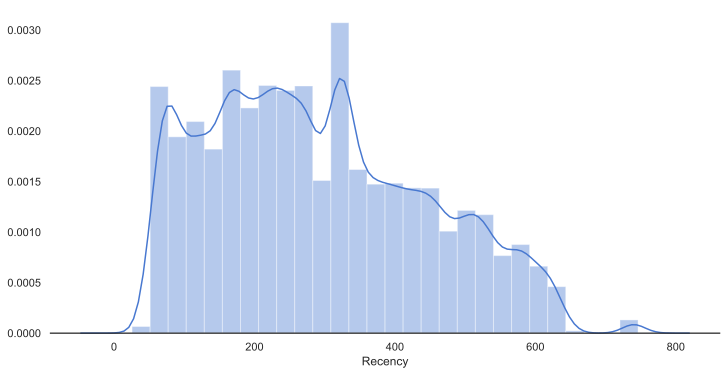

In [8]:
# plotting the distribution 
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

### Frequency
refers to the total number orders for each customer

In [9]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('customer_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_id')

In [10]:
# getting summary statistics of the frequency table
df_user.Frequency.describe()

count   119151.00
mean    1.67     
std     2.39     
min     1.00     
25%     1.00     
50%     1.00     
75%     2.00     
max     63.00    
Name: Frequency, dtype: float64

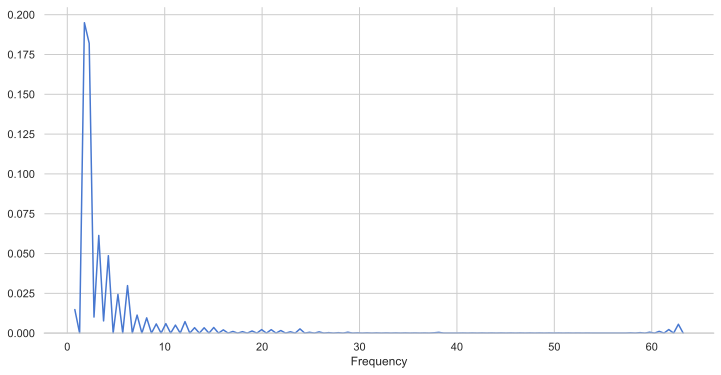

In [11]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show();

In [12]:
#calculate revenue for each customer
df_revenue = df.groupby('customer_id').payment_value.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_id')

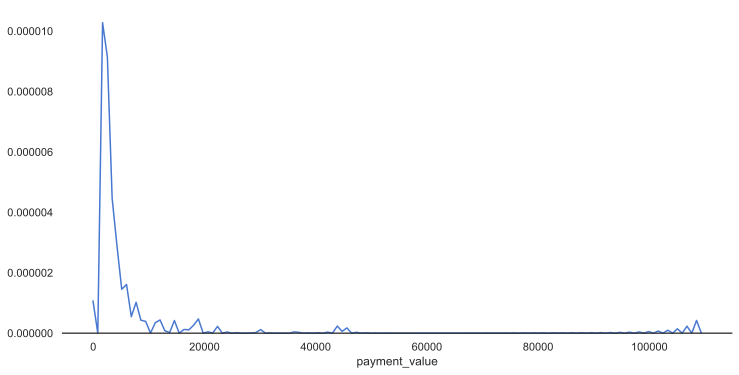

In [13]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show();

In [14]:
df_user.head()

,customer_id,Recency,Frequency,payment_value
0,08c5351a6aca1c1589a38f244edeee9d,772,2,272.46
1,08c5351a6aca1c1589a38f244edeee9d,772,2,272.46
2,683c54fc24d40ee9f8a6fc179fd9856c,772,1,75.06
3,622e13439d6b5a0b486c435618b2679e,764,1,40.95
4,86dc2ffce2dfff336de2f386a786e574,762,3,0.00


In [15]:
# with open('../data/processed/df_user_rfm.pkl', 'wb') as to_write: 
#     pickle.dump(df_user, to_write)

In [24]:
# with open('../data/processed/master_df.pkl', 'wb') as to_write: 
#     pickle.dump(df, to_write)

In [3]:
df_revenue = df.groupby(['year_month'])['payment_value'].sum().reset_index()
# using pct_change() function to see monthly percentage change
df_revenue['MonthlyGrowth'] = df_revenue['payment_value'].pct_change()

df_revenue

,year_month,payment_value,MonthlyGrowth
0,2016-09,388.47,nan
1,2016-10,76979.13,197.16
2,2016-12,19.62,-1.00
3,2017-01,190806.27,9724.09
4,2017-02,351848.13,0.84
5,2017-03,547769.84,0.56
6,2017-04,512126.52,-0.07
7,2017-05,737425.31,0.44
8,2017-06,613777.41,-0.17
9,2017-07,749242.84,0.22


In [ ]:
# # dropping missing values
# df.dropna(inplace=True)
# df.isnull().values.any()

In [39]:
df.head(1)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month
0,b81ef226f3fe1789b1e8b2acac839d17,1.00,credit_card,8.00,99.33,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,1.00,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,casa_construcao,57.00,921.00,8.00,800.00,17.00,27.00,17.00,home_construction,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG,2018,4,2,22,04-2018,2018-04


In [134]:
df_user_features['num_products_bought'].value_counts()

1    95430
2    2846 
0    775  
3    298  
4    70   
6    10   
5    8    
7    3    
8    1    
Name: num_products_bought, dtype: int64

In [96]:
df.sort_values('order_purchase_timestamp', inplace=True)    
df['hours_since_prior_order'] = \
    [str(n) if n > pd.Timedelta(hours=1) else 'immediate' if pd.notnull(n) else 0 
     for n in df.groupby('customer_id', sort=False)['order_purchase_timestamp'].diff()]

In [97]:
df['hours_since_prior_order'].unique()

array([0, 'immediate'], dtype=object)

In [98]:
df['repeated_customer'] = df.duplicated('customer_id', keep=False)
repeated_customers = df.loc[df['repeated_customer']==True]
repeated_customers.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month,hours_since_prior_order,repeated_customer
33568,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2.00,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,41.00,754.00,3.00,1800.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09,0,True
33567,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,1.00,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,59.00,426.00,2.00,1400.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09,immediate,True
118433,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,3.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,0,True
118431,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,1.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,immediate,True
118432,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,2.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,immediate,True
68407,36989eb07a0de2d3d3129eea35553875,1.00,credit_card,10.00,101.44,aadd27185177fc7ac9b364898ac09343,delivered,2016-10-04 13:11:29,2016-10-04 13:46:31,2016-10-08 13:46:32,2016-10-11 13:46:32,2016-12-06,2.00,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,2016-10-08 13:46:32,23.90,26.82,moveis_decoracao,33.00,259.00,2.00,1500.00,65.00,15.00,15.00,furniture_decor,f176923a0a4ab546c7287791ccb82193,78075,cuiaba,MT,2016,10,1,13,10-2016,2016-10,0,True
68406,36989eb07a0de2d3d3129eea35553875,1.00,credit_card,10.00,101.44,aadd27185177fc7ac9b364898ac09343,delivered,2016-10-04 13:11:29,2016-10-04 13:46:31,2016-10-08 13:46:32,2016-10-11 13:46:32,2016-12-06,1.00,43bb8825dd6838251606e5e4130cfff4,939f6e231201f26803cb5c3a3d2940b3,2016-10-08 13:46:32,23.90,26.82,moveis_decoracao,33.00,259.00,2.00,1500.00,65.00,15.00,15.00,furniture_decor,f176923a0a4ab546c7287791ccb82193,78075,cuiaba,MT,2016,10,1,13,10-2016,2016-10,immediate,True
10240,63638a6806d67773f3ad

checkpoint!

In [2]:
with open('../data/interim/master_df.pkl', 'rb') as read_file:
    df = pickle.load(read_file)  

In [4]:
df['product_category_name_english'].value_counts()

bed_bath_table                             11990
health_beauty                              10033
sports_leisure                             9005 
furniture_decor                            8833 
computers_accessories                      8151 
housewares                                 7380 
watches_gifts                              6213 
telephony                                  4726 
garden_tools                               4590 
auto                                       4400 
toys                                       4281 
cool_stuff                                 3999 
perfumery                                  3589 
baby                                       3204 
electronics                                2847 
stationery                                 2625 
fashion_bags_accessories                   2170 
pet_shop                                   2030 
office_furniture                           1788 
consoles_games                             1192 
luggage_accessories 

In [12]:
null_payment = df.loc[df['payment_value'].isnull()]
null_payment
null_payment_copy = null_payment.copy()
null_payment_copy['is_duplicated'] = null_payment_copy.duplicated(features, keep=False)
dup_transactions1 = null_payment_copy.loc[null_payment_copy['is_duplicated']==True]
dup_transactions1

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month,hours_since_prior_order,repeated_customer,review_id,review_score
4,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,3.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,0,True,6916ca4502d6d3bfd39818759d55d536,1
5,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,1.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,immediate,True,6916ca4502d6d3bfd39818759d55d536,1
6,bfbd0f9bdef84302105ad712db648a6c,nan,NaN,nan,nan,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,2.00,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.00,1036.00,1.00,1000.00,16.00,16.00,16.00,health_beauty,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016,9,3,12,09-2016,2016-09,immediate,True,6916ca4502d6d3bfd39818759d55d536,1


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month,hours_since_prior_order,repeated_customer,review_id,review_score,is_duplicated


In [16]:
df.loc[df['customer_id']=='08c5351a6aca1c1589a38f244edeee9d']

,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,month_year,year_month,hours_since_prior_order,repeated_customer,review_id,review_score
0,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2.00,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,41.00,754.00,3.00,1800.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09,0,True,cef1ee03ded4d6272894a2eead6e1328,1
1,2e7a8482f6fb09756ca50c10d7bfc047,1.00,credit_card,1.00,136.23,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,1.00,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,59.00,426.00,2.00,1400.00,32.00,6.00,28.00,furniture_decor,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016,9,6,21,09-2016,2016-09,immediate,True,cef1ee03ded4d6272894a2eead6e1328,1


In [8]:
products['product_category_name'].value_counts()

cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
casa_conforto_2                     5
fashion_roupa_infanto_juvenil       5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 73, dtype: int64

In [10]:
df1 = pd.merge(order_items, products, how = 'left', on = 'product_id')
df1.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0


In [13]:
df1.groupby('product_category_name')['price'].describe().sort_values(by='count', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
product_category_name,,,,,,,,
cama_mesa_banho,11115.0,93.296327,82.128028,6.99,47.990,79.05,115.000,1999.98
beleza_saude,9670.0,130.163531,179.499147,1.20,39.990,79.90,129.900,3124.00
esporte_lazer,8641.0,114.344285,162.471635,4.50,44.320,78.00,129.990,4059.00
moveis_decoracao,8334.0,87.564494,88.832037,4.90,39.900,65.49,99.900,1899.00
informatica_acessorios,7827.0,116.513903,169.974919,3.90,39.900,81.99,149.000,3699.99
utilidades_domesticas,6964.0,90.788148,141.533996,3.06,32.000,59.80,114.095,6735.00
relogios_presentes,5991.0,201.135984,256.742470,8.99,59.940,129.00,209.990,3999.90
telefonia,4545.0,71.213978,135.765167,5.00,21.990,29.99,49.000,2428.00
ferramentas_jardim,4347.0,111.630196,200.534192,6.35,49.900,59.90,99.900,3930.00
